# Linear Regression Neural Net

In [1]:
import tenseal as ts
import numpy as np
import torch

from torch import nn
from torch import optim
import matplotlib.pyplot as plt

In [2]:
class FCLinReg(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size,input_size)
        self.fc2 = nn.Linear(input_size, 2)
        # self.fc3 = nn.Linear(input_size, 2)
        
    def forward(self, x):
        x = self.fc1(x).square()
        x = self.fc2(x) #.square()
        # x = self.fc3(x)
        return x

In [3]:
def linreg(y):
    X = np.linspace(0,1,len(y))
    return np.polyfit(X,y,1)
    

In [4]:
# synthetic training data
l = 50000  # data set length
N = 16     # number of inputs

X = np.array([np.random.uniform(0,1,N) for _ in range(l)])
Y = np.array([linreg(x) for x in X])
print(X.shape)

(50000, 16)


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

In [6]:
# Initialize our model
model = FCLinReg(X.shape[1])

# Define our loss function
loss_fct = nn.MSELoss()

# Define our optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Define the number of iterations
epochs = 10000

# Define the batch size
batch_size = 16

In [7]:
def train():
    for epoch in range(epochs):
        # Get a random batch of training data
        idx = torch.randperm(X_train.size()[0])
        X_batch = X_train[idx][:batch_size]
        y_batch = y_train[idx][:batch_size]

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = loss_fct(y_pred, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()


        if epoch > 0 and epoch % 1000 == 0:
            print(f'Iterations: {epoch:5} | Loss: {loss.item():.9f}')
            if loss.item() < 1e-9:
                break

    print("Training done")

In [8]:
train()

Iterations:  1000 | Loss: 0.001466808
Iterations:  2000 | Loss: 0.002138158
Iterations:  3000 | Loss: 0.000672379
Iterations:  4000 | Loss: 0.000535876
Iterations:  5000 | Loss: 0.000820029
Iterations:  6000 | Loss: 0.000425594
Iterations:  7000 | Loss: 0.000294358
Iterations:  8000 | Loss: 0.000354404
Iterations:  9000 | Loss: 0.000334294
Training done


In [9]:
y_pred = model(X_test)
print(f"mean error: {(y_pred - y_test).abs().mean()}")

mean error: 0.012280757538974285


Analytic:
k = 0.2735
d = 0.2672

NN:
a = 0.2506
b = 0.2972


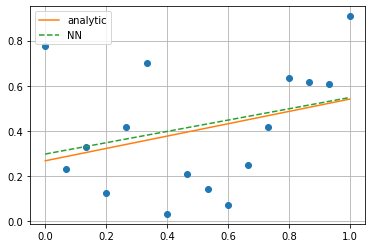

In [13]:
# Example inference
np_inp = np.random.uniform(0,1,N)
inp = torch.tensor(np_inp).float()
plt.plot(np.linspace(0,1,N),np_inp,"o")

# analytic
k,d = linreg(np_inp)
print(f"Analytic:\nk = {k:.4f}\nd = {d:.4f}")

plt.plot([0,1],[d, k+d], label="analytic")

# NN
pred = model(inp)
a = pred[0].item()
b = pred[1].item()
print(f"\nNN:\na = {a:.4f}\nb = {b:.4f}")
plt.plot([0,1],[b, a+b], "--", label = "NN")

plt.legend()
plt.grid()
plt.show()

In [14]:
params = dict()

params["fc1_w"] = model.fc1.weight.T.data
params["fc1_b"] = model.fc1.bias.data
params["fc2_w"] = model.fc2.weight.T.data
params["fc2_b"] = model.fc2.bias.data
# params["fc3_w"] = model.fc3.weight.T.data
# params["fc3_b"] = model.fc3.bias.data

q = params["fc1_w"]
print(q.shape)

torch.Size([16, 16])


In [15]:
class HE_LinReg():
    def __init__(self,params):
        self.fc1_w = params["fc1_w"]
        self.fc1_b = params["fc1_b"]
        self.fc2_w = params["fc2_w"]
        self.fc2_b = params["fc2_b"]
        # self.fc3_w = params["fc3_w"]
        # self.fc3_b = params["fc3_b"]
        
        self.ctx = None
        
    def setupHE(self, context):
        self.ctx = ts.context_from(context)
    
    def forward(self, x):
        # x = ts.ckks_vector_from(self.ctx, x) # only necessary if x is serialized
        # fc1 layer
        x = x.mm(self.fc1_w) + self.fc1_b        
        x.square_()
        # fc2 layer
        x = x.mm(self.fc2_w) + self.fc2_b
        # x.square_()
        # fc3 layer
        # x = x.mm(self.fc3_w) + self.fc3_b
        return x #.serialize()
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [16]:
# SEAL Context
bits_scale = 40
    
# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[49, bits_scale, bits_scale, bits_scale, 49]
)

context.global_scale = pow(2, bits_scale)
context.generate_galois_keys()

In [17]:
server_context = context.copy()
server_context.make_context_public()
server_context = server_context.serialize()

HE_model = HE_LinReg(params)
    
HE_model.setupHE(server_context)

In [18]:
x_test = np.linspace(0.1,0.9,N) + np.random.uniform(-0.1, 0.1, N)

x_enc = ts.ckks_vector(context, x_test)

output_enc = HE_model(x_enc)
result = output_enc.decrypt()

print(result)

print(model(torch.tensor(x_test).float()))

[0.7538084088477955, 0.13877869775640495]
tensor([0.7538, 0.1367], grad_fn=<AddBackward0>)


Analytic:
k = 0.17678
d = 0.46491

NN:
k = 0.18891
d = 0.45267

HE:
k = 0.18891
d = 0.45321


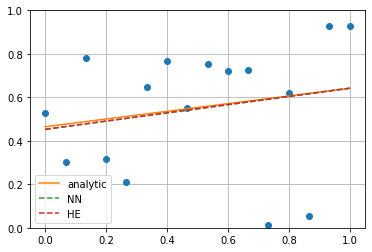

In [32]:
# Inference

x_test = np.random.uniform(0,1,N)
# x_test = np.linspace(0.1,0.9,N) + np.random.uniform(-0.1, 0.1, N)

# Encrypt
x_enc = ts.ckks_vector(context, x_test)
# Model
output_enc = HE_model(x_enc)
he_k, he_d = output_enc.decrypt()

k,d = linreg(x_test)
print(f"Analytic:\nk = {k:.5f}\nd = {d:.5f}")
plt.plot(np.linspace(0,1,N), x_test, "o")
plt.plot([0,1],[d, k+d], label="analytic")

# NN
nn_k, nn_d = model(torch.tensor(x_test).float())
print(f"\nNN:\nk = {nn_k:.5f}\nd = {nn_d:.5f}")
plt.plot([0,1],[nn_d, nn_k+nn_d], "--", label = "NN")

print(f"\nHE:\nk = {he_k:.5f}\nd = {he_d:.5f}")
plt.plot([0,1],[he_d, he_k+he_d], "--", label = "HE")

plt.ylim([0,1])
plt.legend()
plt.grid()
plt.show()